# Assignment3 - Dask
##### Stefanela Stevanovic, 63220492

## Introduction

The goal of this assignment is to use data from https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data to predict the trip distance for NYC Yellow Taxi rides. Given the dataset's significant size, we will utilize Dask to facilitate parallelization across multiple workers, enhancing computational efficiency. We will implement three predictive models - linear regression, decision tree and random forest regression, and evaluate each model's performance based on the Root Mean Square Error (RMSE) metric with 5-fold cross-validation technique. Additionally, for the decision tree and random forest models, we will employ grid search with cross-validation to find the optimal set of hyperparameters.

## Getting Started

First, we begin by importing all the necessary libraries required for this project and connecting to Local cluster using Dask distributed 'Client'.  The configuration for our setup involves 6 workers, each with 2 threads and the memory limit of 5GB per worker. This specific setup was determined through a process of trial and error. We utilized the Dask Dashboard to monitor the usage of CPU and memory resources and based on these observations, we optimized the settings to ensure that there are no idle workers while also preventing the system from approaching the memory limits.

In [1]:
# import needed libraries
import time
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
from dask_ml.metrics import mean_squared_error
from dask_ml.preprocessing import StandardScaler
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('distributed.shuffle._scheduler_plugin').setLevel(logging.ERROR)
logging.getLogger('distributed.scheduler').setLevel(logging.ERROR)

In [2]:
client = Client(n_workers=6, threads_per_worker=2, memory_limit='5GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 27.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54956,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 27.94 GiB
Comm: tcp://127.0.0.1:54998,Total threads: 2
Dashboard: http://127.0.0.1:55006/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:54959,


In [3]:
# load data 
ddf_2015 = dd.read_csv('Data/yellow_tripdata_2015-01.csv', blocksize=100e6)
ddf_2016 = dd.read_csv('Data/yellow_tripdata_2016-01.csv', blocksize=100e6, dtype={'tip_amount': 'float64', 'tolls_amount': 'float64'})   

# fix column name in ddf_2016 to match one in ddf_2015
ddf_2016 = ddf_2016.rename(columns={'RatecodeID': 'RateCodeID'})

# concatenate ddfs
ddf = dd.concat([ddf_2015, ddf_2016], axis=0)

# number of partitions
print(f"Number of partitions: {ddf.npartitions}")

# total number of data points in the ddf
n = ddf.shape[0].compute()
print(f"Total data points: {n}")

Number of partitions: 36
Total data points: 23655844.0


In [4]:
ddf.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


Our task is to predict trip distance (the elapsed trip distance in miles reported by the taximeter), meaning 'trip_distance' will be our dependent variable. For that purpose we can use some or all of the following features:

* VendorID - A code indicating the TPEP provider that provided the record, where 1 = Creative Mobile Technologies and 2 = VeriFone Inc.
* tpep_pickup_datetime - The date and time when the meter was engaged.
* tpep_dropoff_datetime - The date and time when the meter was disengaged.
* passenger_count - The number of passengers in the vehicle. This is a driver-entered value.
* pickup_longitude - Longitude where the meter was engaged.
* pickup_latitude - Latitude where the meter was engaged.
* RateCodeID - The final rate code in effect at the end of the trip, where 1 = Standard rate, 2 = JFK, 3 = Newark, 4 = Nassau or Westchester, 5 = Negotiated fare and 6 = Group ride.
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server, where Y = store and forward trip and N = not a store and forward trip.
* dropoff_longitude - Longitude where the meter was disengaged.
* dropoff_latitude - Latitude where the meter was disengaged.
* payment_type - A numeric code signifying how the passenger paid for the trip, wher 1 = Credit Card and 2 = Cash, 3 = No charge, 4 = Dispute, 5 = Unknown, 6 = Voided trip.
* fare_amount - The time-and-distance fare calculated by the meter.
* extra - Miscellaneous extras and surcharges. Currently, this only includes the 0.50 dollar and 1 dollar rush hour and overnight charges.
* mta_tax - 0.50 MTA tax that is automatically triggered based on the metered rate in use.
* tip_amount - This field is automatically populated for credit card tips. Cash tips are not included.
* tolls_amount - Total amount of all tolls paid in trip.
* improvement_surcharge - 0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.
* total_amount - The total amount charged to passengers. Does not include cash trips.

## Data preprocessing

From the description of the features, it's evident that some are not beneficial for predicting the dependent variable. For example, features such as 'mta_tax' and 'improvement_surcharge' are supposed to be constant values and can be dropped immediately. Furthermore, we can also consider the columns 'store_and_fwd_flag' and 'VendorID' to be of no significance in predicting 'trip_distance'.

In [4]:
ddf = ddf.drop(['mta_tax', 'improvement_surcharge', 'store_and_fwd_flag', 'VendorID'], axis=1)

#### Check for missing values

Fortunately for us, there are no missing values, so we can just continue with our analysis.

In [5]:
nan_counts = ddf.isna().sum().compute()
print(nan_counts)

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
tip_amount               0
tolls_amount             0
total_amount             0
dtype: int64


#### Handling datetime features

From tpep_pickup_datetime and tpep_dropoff_datetime we created three features:
* day_of_week - Day of the week when trip happened (0 = Monday, 6 = Sunday)
* hour - Hour in which pickup happened.
* trip_duration - Calculated as difference in minutes between dropoff and pickup time.

In [6]:
# convert to datetime format
ddf['tpep_pickup_datetime'] = dd.to_datetime(ddf['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
ddf['tpep_dropoff_datetime'] = dd.to_datetime(ddf['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

# create new columns hour and day_of_week
ddf['day_of_week'] = ddf['tpep_pickup_datetime'].dt.dayofweek 
ddf['hour'] = ddf['tpep_pickup_datetime'].dt.hour

# compute trip duration in minutes
ddf['trip_duration'] = ((ddf['tpep_dropoff_datetime'] - ddf['tpep_pickup_datetime']).dt.total_seconds())/60

# drop columns
ddf = ddf.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

#### Encoding

Since we don't expect exact day of the week to play significant role, we will encode it into a binary variable weekend, marking Saturday and Sunday as 1, and rest of the days as 0.

In [7]:
ddf['weekend'] = ddf['day_of_week'].map(lambda x: 0 if x < 5 else 1, meta=('weekend', 'int64'))
ddf = ddf.drop(['day_of_week'], axis=1)

#### Handling coordinates features


The pickup and dropoff longitude and latitude, by themselves, may not provide much insight into the trip distance. However, we anticipate that the absolute difference between the pickup and dropoff latitudes, as well as the pickup and dropoff longitudes, will be valuable in estimating trip distance Because of thisy, we will introduce a new feature, 'll_diff', which represents the sum of the absolute differences in both latitude and longitud.e

In [8]:
ll_diff = (abs(ddf['pickup_latitude'] - ddf['dropoff_latitude'])) + (abs(ddf['pickup_longitude'] - ddf['dropoff_longitude']))
ddf = ddf.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)
ddf['ll_diff'] = ll_diff

#### Remove duplicate rows

In [9]:
# drop dulicates
ddf = ddf.drop_duplicates()

#### Remove outliers and invalid values

Firstly we want to check statistics on features, such as minimum and maximum values. These values will indicate if there are negative values for features that shouldn't have negative values, or if there are outliers that are nonsensical and should be removed.

In [12]:
# statistics on columns
ddf.describe().compute()

,passenger_count,trip_distance,RateCodeID,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,hour,trip_duration,weekend,ll_diff
count,2.363899e+07,2.363899e+07,2.363899e+07,2.363899e+07,2.363899e+07,2.363899e+07,2.363899e+07,2.363899e+07,2.363899e+07,2.363899e+07,2.363899e+07,2.363899e+07,2.363899e+07
mean,1.676991e+00,9.403154e+00,1.037925e+00,1.368231e+00,1.217762e+01,3.105060e-01,1.807314e+00,2.666573e-01,1.535930e+01,1.355789e+01,1.469020e+01,3.028431e-01,4.895489e-01
std,1.332240e+00,7.507586e+03,6.028548e-01,4.954035e-01,2.531323e+01,5.180946e-01,8.125484e+02,1.607250e+00,8.129748e+02,6.402820e+00,4.804769e+02,4.594879e-01,7.144001e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-9.576000e+02,-7.900000e+01,-2.208000e+02,-2.600000e+01,-9.584000e+02,0.000000e+00,-1.211017e+03,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.300000e+00,9.000000e+00,6.216667e+00,0.000000e+00,1.541138e-02
50%,1.000000e+00,1.690000e+00,1.000000e+00,1.000000e+00,9.000000e+00,0.000000e+00,1.160000e+00,0.000000e+00,1.130000e+01,1.400000e+01,1.021667e+01,0.000000e+00,2.652359e-02
75%,2.000000e+00,3.050000e+00,1.000000e+00,2.000000e+00,1.350000e+01,5.000000e-01,2.200000e+00,0.000000e+00,1.680000e+01,1.900000e+01,1.631667e+01,1.000000e+00,4.867554e-02
max,9.000000e+00,1.542000e+07,9.900000e+01,5.000000e+00,1.112709e+05,9.999900e+02,3.950589e+06,1.450090e+03,3.950612e+06,2.300000e+01,5.485556e+05,1.000000e+00,6.661709e+02


By checking the values in the table above, we can already identify some outliers and invalid values. Columns such as 'fare_amount', 'extra', 'tip_amount', 'tolls_amount' and 'total_amount' contain negative values, which must be removed since payments cannot be negative. Similarly, 'trip_distance', 'trip_duration' and 'll_diff' have 0 values, as if the trip didn't even happen. Furthemore, there are some extremly high values in 'trip_distance', 'fare_amount' and 'total_amount', that should be removed. 

In [13]:
# remove rows with negative values
ddf = ddf[(ddf['trip_distance'] > 0) & (ddf['fare_amount'] > 0) & (ddf['tip_amount'] >= 0)& (ddf['tolls_amount'] >= 0) & (ddf['total_amount'] > 0)]

# remove rows where trip_distance, trip_duration, latitude_diff and longitude_diff are 0
ddf = ddf[(ddf['trip_duration'] != 0)  & (ddf['ll_diff'] != 0)]

# remove unreasonably high outliers
upper_bound = 400
ddf = ddf[(ddf['trip_distance'] <= 100) & (ddf['fare_amount'] <= upper_bound) & (ddf['tip_amount'] <= upper_bound) & (ddf['tolls_amount'] <= upper_bound)]
ddf = ddf[ddf['ll_diff'] < 2]

# keep only trips that lasted between 1min and 2 hours
ddf = ddf[(ddf['trip_duration'] <= 120) & (ddf['trip_duration'] > 1)]

# remove invalid values
ddf = ddf[(ddf['extra'] <= 1) & (ddf['RateCodeID'] <= 6)]

Next, we will check the speed of the driver. We don't know laws on speed limits in New York city, but if on some route we get average speed over 120 km/h, we can assume that the data was not correctly collected and we can drop such rows.

In [14]:
# calculate speed in miles per hour
ddf['speed_mph'] = ddf['trip_distance'] / (ddf['trip_duration'] / 3600)

# speed limit in miles per hour
speed_limit = 120 / 1.60934

# filter ddf
ddf = ddf[ddf['speed_mph'] > speed_limit]
ddf = ddf.drop(['speed_mph'], axis=1)

Lastly, we want to check how much data we have lost during the cleaning process to make sure we didn't put the upper bounds for filtering too high. 

In [15]:
# persist ddf for faster computation
ddf_persisted = ddf.persist()

# total number of data points in the ddf
n2 = ddf_persisted.shape[0].compute()
print(f"Total data points after data cleaning: {n2}")
print(f"Percentage of lost data after cleaning: {100*(n-n2)/n} %")

Total data points after data cleaning: 22909973.0
Percentage of lost data after cleaning: 3.153009463538904 %


#### Feature selection

To analyze the correlation between different features and between dependent variable and features, we will plot correlation matrix. Usually we want to to this only on the training set, to prevent any look-ahead bias, which occurs when information from the test set is used to influence the training process. However, we want to evaluate our model with 5-fold cross-validation, meaning each data point will eventually end up in the training set. We can minimize this bias of performing correlation analysis on the whole dataset by limiting the analysis to a random sample that will only contain 5% of the original data, which will also help will faster computation.

In [16]:
# create smaller sample dataframe
sample_ddf = ddf.sample(frac=0.05, random_state=89)

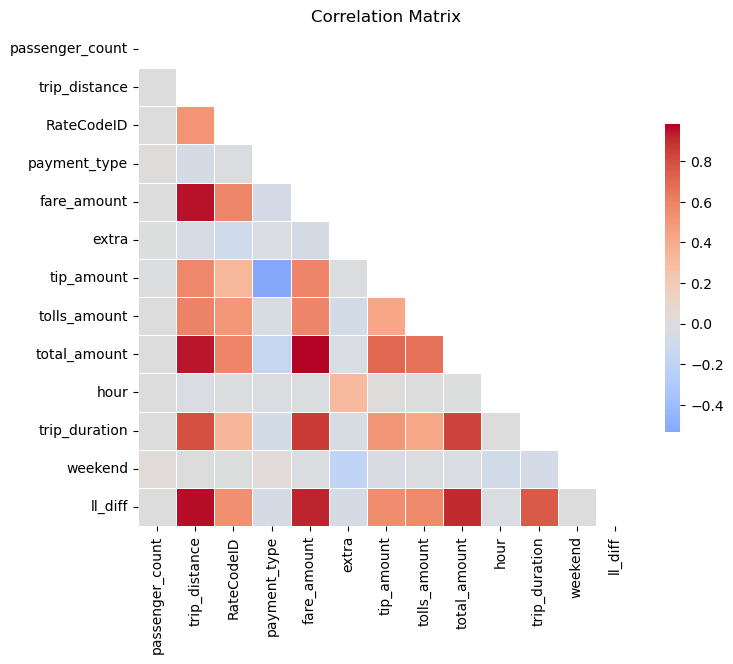

CPU times: total: 3min 16s
Wall time: 4min 50s


In [17]:
%%time

# create correlation matrix
corr_matrix = sample_ddf.corr().compute()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".2f")

plt.title('Correlation Matrix')
plt.show()

From the correlation matrix, we see that 'fare_amount', 'total_amount', 'll_diff' (the sum of the absolute differences in latitude and longitude), and 'trip_duration' are highly correlated with 'trip_distance', our dependent variable. Given that 'total_amount' is essentially 'fare_amount' with added tips, tolls, taxes, and extras, we will omit it from further analysis. We will focus instead on 'fare_amount' that directly depends on the distance and duration of the trip. We can expect to get great results only by using 'fare_amount' and 'trip duration' to predict 'trip_distance', because we know that 'fare_amount' is calculated only based on time and distance of the trip. We will also include 'll_diff' in analysis, because we can expect it to be significant in randomized models like Random Trees. In case of one of three features having incorrect input, others two will be able to balance it out.

In [18]:
# remove columns that we won't use
ddf = ddf.drop(['passenger_count', 'payment_type', 'total_amount', 'tip_amount', 'tolls_amount', 'RateCodeID', 'hour', 'weekend', 'extra'], axis=1) 

#### Data visualization

Next, we will plot the distribution of dependent variable trip_distance and the features we will use for training the models: fare_amount, trip_duration and ll_diff. We already persisted ddf for faster computation, so we will just bring the relavant columns into local memory to plot them.

In [19]:
# bring relevant columns into local memory
ll_diff = ddf_persisted['ll_diff'].compute()
trip_duration = ddf_persisted['trip_duration'].compute()
fare_amount = ddf_persisted['fare_amount'].compute()
trip_distance = ddf_persisted['trip_distance'].compute()

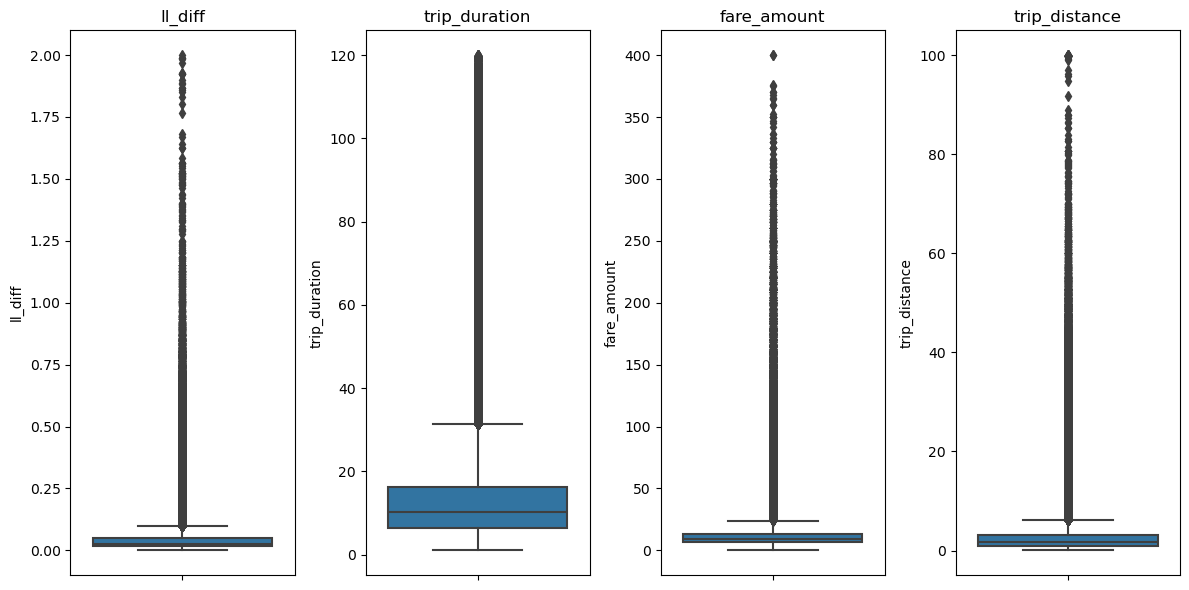

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))

sns.boxplot(y=ll_diff, ax=axs[0])
axs[0].set_title('ll_diff')

sns.boxplot(y=trip_duration, ax=axs[1])
axs[1].set_title('trip_duration')

sns.boxplot(y=fare_amount, ax=axs[2])
axs[2].set_title('fare_amount')

sns.boxplot(y=trip_distance, ax=axs[3])
axs[3].set_title('trip_distance')

plt.tight_layout()
plt.show()

Our plots suggest that we still have some 'outliers'. However, those 'outliers' are not something that is impossible or unreasonable to happen. In 23 million rides we can expect at least some to take around 2 hours or to be around 100 miles. 

In [20]:
# remove persisted ddf
client.cancel(ddf_persisted)
del ddf_persisted

## Machine Learning models

### Linear regression

In this section, we implemented a linear regression model with 5-Fold cross-validation to evaluate the performance. The features were standardized using StandardScaler to ensure uniformity across different scales, which is crucial for linear regression model. The root mean squared error (RMSE) was computed for each fold, as a measure of the model's predictive accuracy.

In [22]:
# split X (independent variables) and y (dependent variable)
def split_X_y(ddf):
    X = ddf.drop(columns=['trip_distance'])
    X = X.to_dask_array(lengths=True)
    y = ddf.trip_distance
    y = y.to_dask_array(lengths=True)
    return X, y

In [27]:
X, y = split_X_y(ddf)
scaler = StandardScaler()
kf = KFold(n_splits=5, shuffle=True)

rmse_scores = []
lr_coeffs = []
fold = 1
for train_index, test_index in kf.split(X):
    start = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # standardize features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LinearRegression(solver='lbfgs', max_iter=10)
    model.fit(X_train, y_train)
    lr_coeffs.append(model.coef_)
    
    y_pred = model.predict(X_test)

    # compute rmse
    rmse = sqrt(mean_squared_error(y_test, y_pred))  
    rmse_scores.append(rmse)
    
    end = time.time()
    print(f"Fold {fold} finished in {end-start} s.")
    fold += 1

Fold 1 finished in 1130.6909530162811 s.
Fold 2 finished in 1095.9052572250366 s.
Fold 3 finished in 1100.8861110210419 s.
Fold 4 finished in 1115.5140647888184 s.
Fold 5 finished in 1117.4705052375793 s.


In [28]:
# calculate average coefficients of linear model
stacked_coeffs = np.vstack(lr_coeffs)
coeffs = np.mean(stacked_coeffs, axis=0)
coeffs_std = np.std(stacked_coeffs, axis=0)

# calculate average score its standard deviation across all folds
lr_rmse = np.mean(rmse_scores)
lr_rmse_std = np.std(rmse_scores)
print(f"Average RMSE for linear model: {lr_rmse}")
print(f"Standard deviation of RMSE: {lr_rmse_std}")

Average RMSE for linear model: 0.7273755466112122
Standard deviation of RMSE: 0.003912132093290482



Next, we will plot the average values of the linear regression coefficients and their standard deviation across 5 folds. However, we must consider that the variables used for training the model are highly correlated, so interpreting feature importance here won't make sense. When variables are highly correlated, it's difficult to determine how each one individually affects the outcome because they can distort each other't importance.

Intercept: 2.8505310554700123


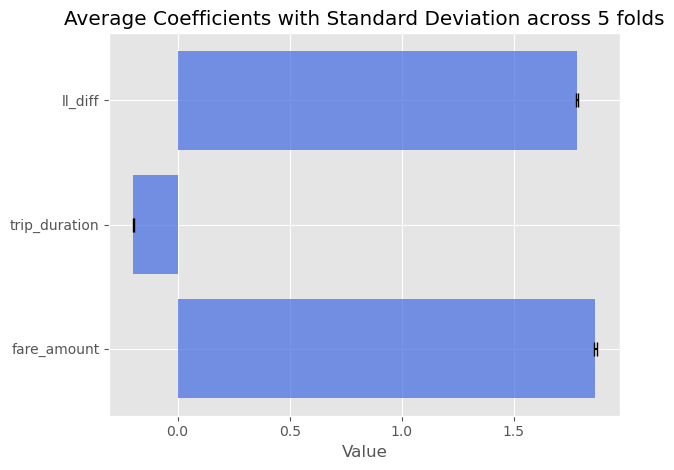

In [45]:
print(f"Intercept: {model.intercept_}")
indices = np.arange(len(coeffs)) 
names = ddf.columns.tolist()
names.remove('trip_distance')

# plot coefficients
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.barh(indices, coeffs, xerr=coeffs_std, align='center', alpha=0.7, ecolor='black', capsize=5, color='royalblue')
ax.set_xlabel('Value')
ax.set_yticks(indices)
ax.set_yticklabels(names)
ax.set_title('Average Coefficients with Standard Deviation across 5 folds')
plt.tight_layout()
plt.show()

### Decision Tree Regression

Next, we will train decision tree model for predicting trip distance using same three features: 'll_diff', 'trip_duration' and 'fare_amount'. Again, we will use RMSE as performance metric and evaluate model using 5-fold cross-validation. In decision tree models standardization of the data doesn't affect the results, so we decided not to standardize. For finding optimal max tree depth we will perform nested cross-validation with grid search - for each iteration of outer 5-fold cross-validation, we will perform 3-fold cross-validation on four folds that belong to the training set, to find optimal tree depth. 

In [25]:
X, y = split_X_y(ddf)
kf = KFold(n_splits=5, shuffle=True)

# parameter grid for grid search
param_grid = {
    'max_depth': [10, 12, 15, 17],
    'min_samples_leaf': [2],
}

dt_scores = []
dt_imp = []
tree_depth = []
fold = 1

# loop through folds
for train_index, test_index in kf.split(X):
    start = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # inner CV for hyperparameter tuning
    dt = DecisionTreeRegressor()
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # extract best model and its parameters
    best_model = grid_search.best_estimator_
    tree_depth.append(grid_search.best_params_)
    dt_imp.append(best_model.feature_importances_)
    
    # get predictions
    y_pred = best_model.predict(X_test)

    # compute RMSE
    rmse = sqrt(mean_squared_error(y_test, y_pred))  
    dt_scores.append(rmse)
    
    end = time.time()
    print(f"Outer fold {fold} finished in {end-start} s.")
    fold += 1

Outer fold 1 finished in 996.61963057518 s.
Outer fold 2 finished in 766.6356868743896 s.
Outer fold 3 finished in 479.16398191452026 s.
Outer fold 4 finished in 484.8270869255066 s.
Outer fold 5 finished in 470.6948380470276 s.


In [26]:
# calculate average rmse and its std across all folds
dt_rmse = np.mean(dt_scores)
dt_rmse_std = np.std(dt_scores)
print(f"Average RMSE for random forest model: {dt_rmse}")
print(f"Standard deviation of RMSE: {dt_rmse_std}")

Average RMSE for random forest model: 0.4668658195179177
Standard deviation of RMSE: 0.0046632545835948985


In [27]:
dt_importances = np.mean(dt_imp, axis=0)
dt_importances_std = np.std(dt_imp, axis=0)

tree_depth

[{'max_depth': 15, 'min_samples_leaf': 2},
 {'max_depth': 15, 'min_samples_leaf': 2},
 {'max_depth': 15, 'min_samples_leaf': 2},
 {'max_depth': 15, 'min_samples_leaf': 2},
 {'max_depth': 12, 'min_samples_leaf': 2}]

We can see above that for 4 out of 5 iterations optimal max_depth was 15, while in the last iteration optimal max_depth was 12. Furthemore, decision tree model offers built-in function to extract feature importance. We will plot those feature importances with their standard deviations accross 5 iterations below.

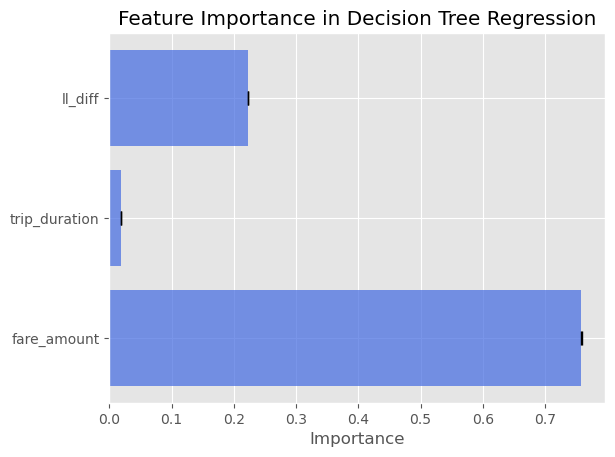

In [33]:
indices = np.arange(3) 
names = ddf.columns.tolist()
names.remove('trip_distance')

# plot importances
fig, ax = plt.subplots()
ax.barh(indices, dt_importances, xerr=dt_importances_std, align='center', alpha=0.7, ecolor='black', capsize=5, color='royalblue')
ax.set_xlabel('Importance')
ax.set_yticks(indices)
ax.set_yticklabels(names)
ax.set_title('Feature Importance in Decision Tree Regression')
plt.show()

### Random Forest Regression

For the random forest regression model, we will use a methodology similar to that used for the decision tree model - we will perform nested cross-validation, with an outer loop of 5 folds for model evaluation and an inner loop of 3 folds on the training data for hyperparameter tuning through grid search. A notable distinction for the random forest model is the grid search parameters: we will be adjusting for 'n_estimators' and 'max_depth'. Specifically, for 'n_estimators', we will test values of 15 and 25, and for 'max_depth', we will explore depths of 8, 10, and 12.g.

IMPORTANT NOTE: Ideally, we would extend our hyperparameter exploration to include a broader range of values for these two parameters, particularly increasing the number of estimators and considering a max depth of 15, which worked well in the decision tree model. In this ideal case we would also optimize other hyperparameters, such as: 'max_features', 'min_samples_leaf' and 'min_samples_split'. However, given the extensive dataset and the approach of nested cross-validation, training duration was pretty long even for such a limited parameter grid (approximately 5 hours and 40 minutes, as shown below). Due to these time constraints, we decided to stick with this simple parameter setting, just for the sake of demonstration.

In [38]:
from dask_ml.model_selection import GridSearchCV

kf = KFold(n_splits=5, shuffle=True)

# parameter grid for grid search
param_grid = {
    'max_features': [2],
    'n_estimators': [15, 25],
    'max_depth': [8, 10, 12]
}

rf_scores = []
rf_imp = []
params = []
fold = 1
for train_index, test_index in kf.split(X):
    start = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # inner CV for hyperparameter tuning
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # extract best model and its parameters
    best_model = grid_search.best_estimator_
    params.append(grid_search.best_params_)
    rf_imp.append(best_model.feature_importances_)
    
    # get predictions
    y_pred = best_model.predict(X_test)

    #compute rmse
    rmse = sqrt(mean_squared_error(y_test, y_pred))  
    rf_scores.append(rmse)
    
    end = time.time()
    print(f"Outer fold {fold} finished in {end-start} s.")
    fold += 1

Outer fold 1 finished in 3773.878001689911 s.
Outer fold 2 finished in 3976.238175868988 s.
Outer fold 3 finished in 3751.420427083969 s.
Outer fold 4 finished in 4193.493458509445 s.
Outer fold 5 finished in 3725.7459874153137 s.


In [39]:
# calculate average rmse and its std across all folds
rf_rmse = np.mean(rf_scores)
rf_rmse_std = np.std(rf_scores)
print(f"Average RMSE for random forest model: {rf_rmse}")
print(f"Standard deviation of RMSE: {rf_rmse_std}")

Average RMSE for random forest model: 0.4509417639759958
Standard deviation of RMSE: 0.005957130376671645


In [46]:
rf_importances = np.mean(rf_imp, axis=0)
rf_importances_std = np.std(rf_imp, axis=0)

params

[{'max_depth': 12, 'max_features': 2, 'n_estimators': 25},
 {'max_depth': 12, 'max_features': 2, 'n_estimators': 25},
 {'max_depth': 12, 'max_features': 2, 'n_estimators': 25},
 {'max_depth': 12, 'max_features': 2, 'n_estimators': 25},
 {'max_depth': 12, 'max_features': 2, 'n_estimators': 25}]

In each iteration, a max_depth of 12 and 25 estimators were the optimal hyperparameter choices. These values are the highest available within the parameter grid for both max_depth and n_parameters. This strongly suggests that higher values should be explored for both hyperparameters, which could likely lead to further improvements in the performance of the random forest model.

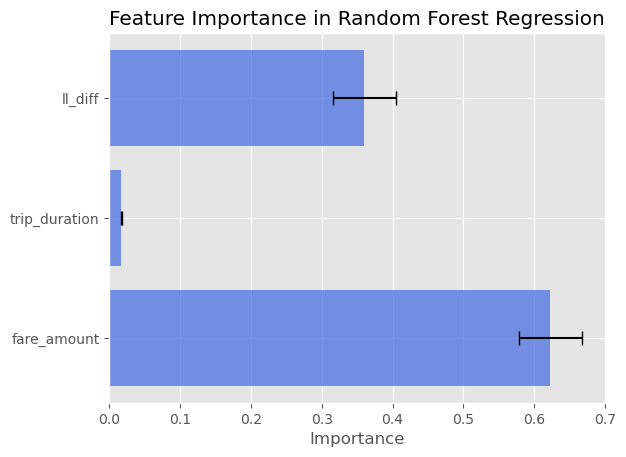

In [44]:
# plot importances
fig, ax = plt.subplots()
ax.barh(indices, rf_importances, xerr=rf_importances_std, align='center', alpha=0.7, ecolor='black', capsize=5, color='royalblue')
ax.set_xlabel('Importance')
ax.set_yticks(indices)
ax.set_yticklabels(names)
ax.set_title('Feature Importance in Random Forest Regression')
plt.show()

## Model comparison


In this section of the report, we willplot  and compare the performance of the three implemented regression models.

[Text(0, 0, 'Linear Regression'),
 Text(0, 1, 'Decision Tree Regression'),
 Text(0, 2, 'Random Forest Regression')]

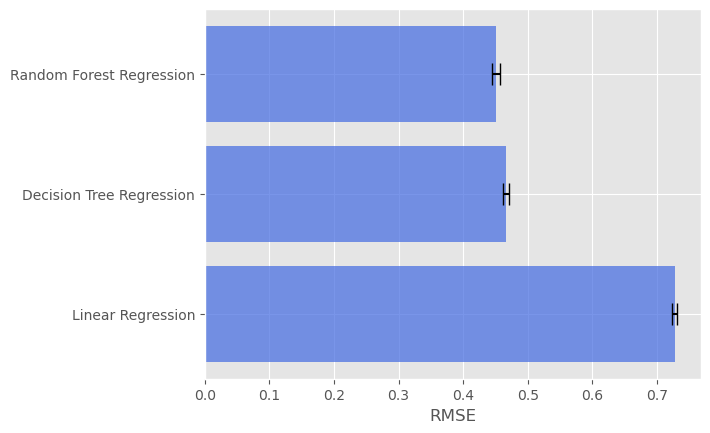

In [32]:
mean_rmse = [lr_rmse, dt_rmse, rf_rmse]
std_rmse = [lr_rmse_std, dt_rmse_std, rf_rmse_std]
model_names = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression']
x_aranged = np.arange(len(model_names))

# plot RMSE comparison
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.barh(x_aranged, mean_rmse, xerr=std_rmse, align='center', alpha=0.7, ecolor='black', capsize=8, color = 'royalblue')
ax.set_xlabel('RMSE')
ax.set_yticks(x_aranged)
ax.set_yticklabels(model_names)

All three models demonstrated low RMSE values, which can be attributed to the features being highly correlated with 'trip_distance' we wanted to predict. Among the three models, linear regression showed the least impressive performance, with an average RMSE of around 0.73. The decision tree model, optimized with a specific max_depth, had an average RMSE of approximately 0.47. The random forest model, with 25 estimators and a maximum depth of 12, performed slightly better, with an average RMSE of 0.45. Although the decision tree and random forest models showed similar performance levels, it's worth noting that the random forest model has greater potential for optimization. The hyperparameters selected for the random forest model are likely not the optimal ones, and we believe that incorporating more estimators and possibly increasing the depth could result in an even lower RMSE for the random forest regression model. Furthermore, both the decision tree and random forest models exhibited a similar distribution of feature importance, with 'fare_amount' being the most significant feature, followed by 'll_diff', and 'trip_duration' being the least important of the three (but still having importance above zero in both models). The standard deviation in feature importance was higher in the random forest model compared to the decision tree model across the 5 folds, which can be attributed to the inherent random nature of the random forest model, selecting a subset of features at random for each tree (estimator) within the model.